In [2]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt

np.random.seed(42)


In [3]:
# Step 2: Download Stock Data (10 years till yesterday)
ticker = "AAPL"  # Try "TSLA", "GOOG", "MSFT", etc.

end_date   = datetime.date.today() - datetime.timedelta(days=1)
start_date = end_date - datetime.timedelta(days=365*10)

df = yf.download(ticker, start=start_date, end=end_date, progress=False).dropna()
print(df.head(), "\nRows:", len(df))


C:\Users\puroh\AppData\Local\Temp\ipykernel_33960\251089534.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False).dropna()


Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-09-01  24.207443  25.142301  24.126542  24.753527  307383600
2015-09-02  25.245672  25.245672  24.524303  24.771503  247555200
2015-09-03  24.802958  25.344545  24.728798  25.279375  212935600
2015-09-04  24.555763  24.820939  24.384973  24.488347  199985200
2015-09-08  25.238930  25.295111  24.791726  25.113084  219374400 
Rows: 2513


In [4]:
# Step 3: Scale Data
features = ['Open', 'High', 'Low', 'Close', 'Volume']

X_raw = df[features].values
y_raw = df[['Open','Close']].values  # targets

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_scaled = x_scaler.fit_transform(X_raw)
y_scaled = y_scaler.fit_transform(y_raw)


In [5]:
# Step 4: Create Dataset function
def create_dataset(X, y, time_step=60):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:i+time_step])      # last 'time_step' rows of features
        ys.append(y[i+time_step])        # predict next day's [Open, Close]
    return np.array(Xs), np.array(ys)

time_step = 60
X_seq, y_seq = create_dataset(X_scaled, y_scaled, time_step)
X_seq.shape, y_seq.shape


((2453, 60, 5), (2453, 2))

In [6]:
# Step 5: Split
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

X_train.shape, X_test.shape


((1962, 60, 5), (491, 60, 5))

In [7]:
# Step 6: Build GRU
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(time_step, X_train.shape[2])),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(2)  # outputs: [Open, Close]
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
model.summary()


c:\Users\puroh\Downloads\GENAI\genai_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,602 (92.20 KB)

 Trainable params: 23,602 (92.20 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Step 7: Train
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0311 - val_loss: 0.0087
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0010 - val_loss: 6.4950e-04
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.6820e-04 - val_loss: 3.3967e-04
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.9633e-04 - val_loss: 3.3368e-04
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.6181e-04 - val_loss: 3.0548e-04
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.4115e-04 - val_loss: 3.3262e-04
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.2742e-04 - val_loss: 2.6347e-04
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.2113e-04 - val_loss: 3.7206e-04
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.1456e-04 - val_loss: 3.1893e-04
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.0749e-04 - val_loss: 3.1646e-04


In [11]:
# Step 8: Evaluate on Test
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

from sklearn.metrics import mean_squared_error
import numpy as np

rmse_open  = np.sqrt(mean_squared_error(y_true[:,0], y_pred[:,0]))
rmse_close = np.sqrt(mean_squared_error(y_true[:,1], y_pred[:,1]))

print(f"RMSE  Open : {rmse_open:.4f}")
print(f"RMSE  Close: {rmse_close:.4f}")



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE  Open : 12.9661
RMSE  Close: 10.6540


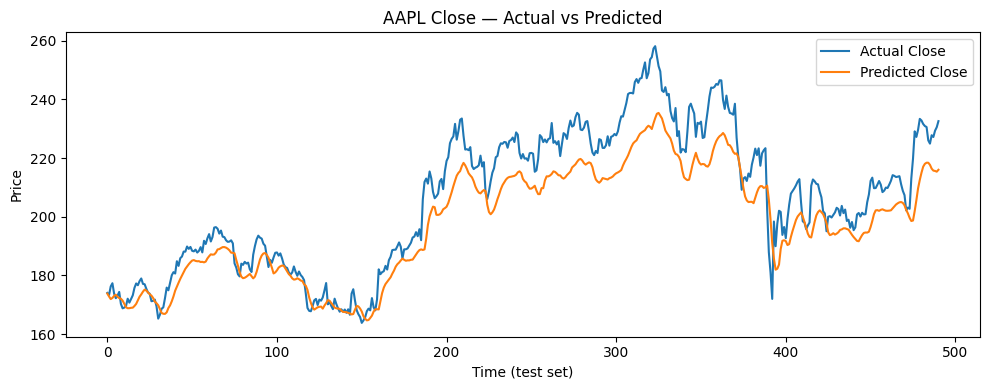

In [12]:
# Step 9: Plot actual vs predicted (Close)
plt.figure(figsize=(10,4))
plt.plot(y_true[:,1], label='Actual Close')
plt.plot(y_pred[:,1], label='Predicted Close')
plt.title(f'{ticker} Close — Actual vs Predicted')
plt.xlabel('Time (test set)')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Step 10: Next-Day Forecast
last_seq = X_scaled[-time_step:]            # last 60 days of scaled features
last_seq = np.expand_dims(last_seq, axis=0) # shape (1, 60, features)

next_scaled = model.predict(last_seq)
next_open, next_close = y_scaler.inverse_transform(next_scaled)[0]

print(f"Predicted next-day Open : {next_open:.2f}")
print(f"Predicted next-day Close: {next_close:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Predicted next-day Open : 213.07
Predicted next-day Close: 216.91


In [16]:
model.save("gru_stock_model.keras")




In [18]:
model = keras.models.load_model("gru_stock_model.keras")
preds = model.predict(X_test)



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [19]:
# --- Last 5 Days: Actual vs Predicted ---
predicted_prices, actual_prices = [], []
lookback_days = 5

for i in range(-lookback_days, 0):
    # Predict
    last_seq = X_scaled[i-time_step:i].reshape(1, time_step, X_seq.shape[2])
    pred_scaled = model.predict(last_seq, verbose=0)
    
    # Inverse transform (Open, Close)
    dummy = np.zeros((1, 5))
    dummy[0,0] = pred_scaled[0,0]  # Open
    dummy[0,3] = pred_scaled[0,1]  # Close
    real_pred = x_scaler.inverse_transform(dummy)[:, [0,3]][0]
    
    predicted_prices.append(real_pred)

    # Actual
    actual = df[['Open','Close']].values[i]
    actual_prices.append(actual)

# Put results into DataFrame
result_df = pd.DataFrame({
    "Actual_Open": [a[0] for a in actual_prices],
    "Pred_Open":   [p[0] for p in predicted_prices],
    "Actual_Close":[a[1] for a in actual_prices],
    "Pred_Close":  [p[1] for p in predicted_prices],
})

print("\n--- Last 5 Days: Actual vs Predicted ---")
print(result_df)



--- Last 5 Days: Actual vs Predicted ---
   Actual_Open   Pred_Open  Actual_Close  Pred_Close
0   226.169998  211.874880    227.759995  216.377317
1   226.479996  211.303543    227.160004  215.707097
2   226.869995  211.244689    229.309998  215.586794
3   228.610001  211.279513    230.490005  215.343033
4   230.820007  212.010860    232.559998  215.987533
